# Ridge Resistance Comparison

This notebook inspects the saved controller rollouts in `trajectories/`, loads each `simulation_stats.json`, and compares the ridge resistance time series across controllers.

In [130]:
from pathlib import Path
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk", palette="colorblind")


def find_repo_root(marker: str = "pyproject.toml") -> Path:
    """Walk up from the current working directory until the repo root is found."""
    current = Path.cwd().resolve()
    for candidate in [current, *current.parents]:
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"Could not locate repository root containing {marker!r}.")


REPO_ROOT = find_repo_root()
TRAJECTORIES_DIR = REPO_ROOT / "trajectories"
print(f"Using trajectories from: {TRAJECTORIES_DIR}")

Using trajectories from: /Users/diegocalanzone/Desktop/rl-optimal-control/final-project/group/AUTO-IceNav/trajectories


In [131]:
def load_ridge_resistance(stats_path: Path) -> pd.DataFrame | None:
    """Return a tidy DataFrame with time/resistance columns for a single run."""
    with stats_path.open() as f:
        stats = json.load(f)

    history = (
        stats.get("trajectories", {}).get("ridge_resistance_history")
        or stats.get("ridge_resistance_history", [])
    )
    if not history:
        print(f"⚠️  {stats_path.parent.name}: 'ridge_resistance_history' is missing or empty")
        return None

    frame = pd.DataFrame(history)
    required = {"time", "resistance"}
    if not required.issubset(frame.columns):
        missing = required.difference(frame.columns)
        print(f"⚠️  {stats_path.parent.name}: missing columns {sorted(missing)}; skipping")
        return None

    return frame.sort_values("time").assign(method=stats_path.parent.name).reset_index(drop=True)

In [132]:
def load_cumulative_ridge_counts(stats_path: Path) -> pd.DataFrame | None:
    """Return cumulative ridge count series for a single run."""
    with stats_path.open() as f:
        stats = json.load(f)

    history = (
        stats.get("trajectories", {}).get("ridge_history")
        or stats.get("ridge_history", [])
        
    )
    if not history:
        print(f"⚠️  {stats_path.parent.name}: 'ridge_history' is missing or empty")
        return None

    frame = pd.DataFrame(history)
    if "time" not in frame.columns:
        print(f"⚠️  {stats_path.parent.name}: 'ridge_history' missing 'time'; skipping")
        return None

    frame = frame.sort_values("time").reset_index(drop=True)
    frame["cumulative_ridges"] = range(1, len(frame) + 1)
    frame["method"] = stats_path.parent.name
    return frame[["time", "cumulative_ridges", "method"]]


In [133]:
frame = load_ridge_resistance(Path("../trajectories/nmpc/simulation_stats.json"))

In [134]:
resistance_records: list[pd.DataFrame] = []
ridge_count_records: list[pd.DataFrame] = []
for method_dir in sorted(TRAJECTORIES_DIR.iterdir()):
    if not method_dir.is_dir():
        continue
    stats_path = method_dir / "simulation_stats.json"
    if not stats_path.exists():
        print(f"ℹ️  {method_dir.name}: no simulation_stats.json; skipping")
        continue

    resistance_frame = load_ridge_resistance(stats_path)
    if resistance_frame is not None:
        resistance_records.append(resistance_frame)

    ridge_count_frame = load_cumulative_ridge_counts(stats_path)
    if ridge_count_frame is not None:
        ridge_count_records.append(ridge_count_frame)

if not resistance_records:
    raise RuntimeError("No ridge resistance histories were found — rerun simulations to generate stats.")

resistance_df = pd.concat(resistance_records, ignore_index=True)
method_durations = (
    resistance_df.groupby('method')["time"].agg(lambda s: s.max() - s.min()).to_dict()
)
ridge_counts_df = (
    pd.concat(ridge_count_records, ignore_index=True)
    if ridge_count_records
    else pd.DataFrame(columns=["time", "cumulative_ridges", "method"])
)
resistance_df.head()

,time,resistance,method
0,1.765677e+09,0.000000,astar
1,1.765677e+09,2.058818,astar
2,1.765677e+09,177.762104,astar
3,1.765677e+09,180.122116,astar
4,1.765677e+09,182.203527,astar


In [135]:
def load_pathline_length(method: str) -> float:
    method_dir = TRAJECTORIES_DIR / method
    for candidate in ('end_path_lines.pkl', 'path_lines.pkl'):
        pickle_path = method_dir / candidate
        if not pickle_path.exists():
            continue
        fig = None
        try:
            with pickle_path.open('rb') as fh:
                fig = pickle.load(fh)
            if not fig.axes or not fig.axes[0].lines:
                raise ValueError('no path lines stored')
            line = fig.axes[0].lines[0]
            x = np.asarray(line.get_xdata(), dtype=float)
            y = np.asarray(line.get_ydata(), dtype=float)
            if x.size < 2:
                return 0.0
            return float(np.sum(np.hypot(np.diff(x), np.diff(y))))
        except Exception as exc:
            print(f"⚠️  {method}: failed to load {candidate} ({exc}); skipping")
        finally:
            if fig is not None:
                plt.close(fig)
    return np.nan

path_length_map = {}
for method_dir in sorted(TRAJECTORIES_DIR.iterdir()):
    if method_dir.is_dir():
        path_length_map[method_dir.name] = load_pathline_length(method_dir.name)


In [136]:
summary = (
    resistance_df.groupby('method')['resistance']
    .agg(count='count', mean='mean', std='std', min='min', max='max')
    .round(3)
)
summary

,count,mean,std,min,max
method,,,,,
astar,27561,18658.276,20349.358,0.0,79398.380
diffusion,27127,27293.536,27389.808,0.0,86900.540
nmpc,33400,823.764,4614.836,0.0,31179.376


In [137]:
if ridge_counts_df.empty:
    raise RuntimeError("No ridge histories were found — rerun simulations to capture ridge events.")

ridge_count_summary = (
    ridge_counts_df.groupby('method')
    .agg(
        total_ridges=('cumulative_ridges', 'max'),
        first_event=('time', 'min'),
        last_event=('time', 'max'),
    )
    .round({'first_event': 2, 'last_event': 2})
)
ridge_count_summary

,total_ridges,first_event,last_event
method,,,
astar,21,1.765677e+09,1.765678e+09
diffusion,13,1.765682e+09,1.765683e+09
nmpc,2,1.765688e+09,1.765688e+09


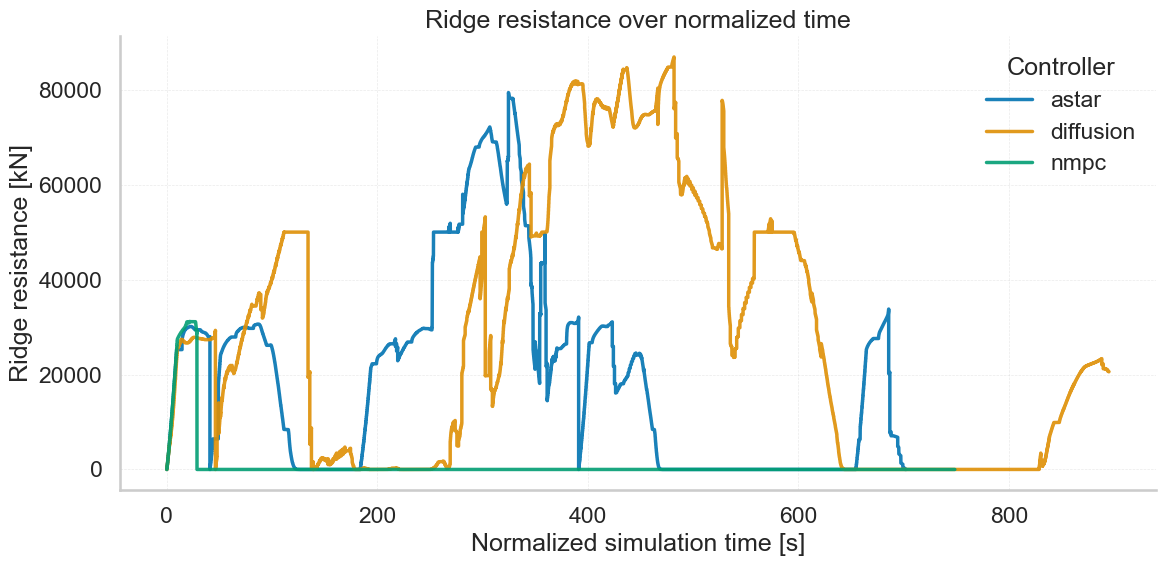

In [138]:
method_order = list(resistance_df['method'].unique())
if "ridge_counts_df" in locals() and not ridge_counts_df.empty:
    for method in ridge_counts_df['method'].unique():
        if method not in method_order:
            method_order.append(method)

palette = sns.color_palette("colorblind", len(method_order))
color_map = dict(zip(method_order, palette))

fig, ax = plt.subplots(figsize=(12, 6))
for method, group in resistance_df.groupby('method'):
    relative_time = group['time'] - group['time'].min()
    method_duration = method_durations.get(method)
    final_time = relative_time.iloc[-1]
    if method_duration is not None and method_duration > final_time:
        relative_time = pd.concat(
            [relative_time, pd.Series([method_duration])], ignore_index=True
        )
        resistance = pd.concat(
            [group['resistance'], pd.Series([group['resistance'].iloc[-1]])],
            ignore_index=True,
        )
    else:
        resistance = group['resistance']

    ax.plot(
        relative_time,
        resistance,
        label=method,
        color=color_map[method],
        linewidth=2.5,
        alpha=0.9,
    )

ax.set_xlabel('Normalized simulation time [s]')
ax.set_ylabel('Ridge resistance [kN]')
ax.set_title('Ridge resistance over normalized time')
ax.legend(title='Controller', frameon=False, loc='upper right')
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.4)
sns.despine()
fig.tight_layout()

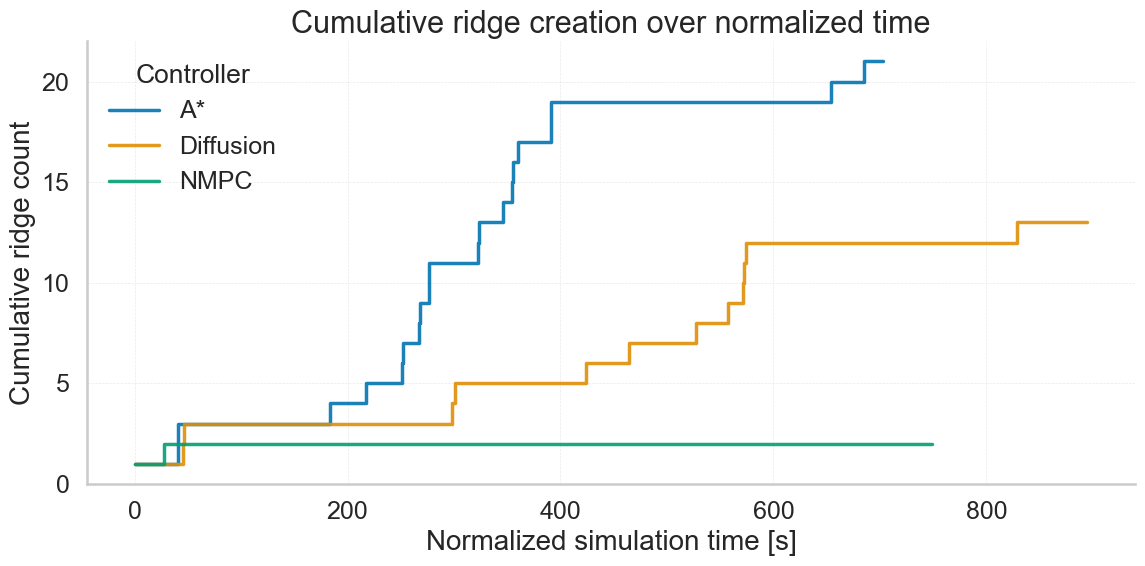

In [139]:
# Mirror the cumulative ridge visualization from ship_ice_planner/evaluation/evaluate_run_sim.py
if ridge_counts_df.empty:
    raise RuntimeError("No ridge histories were found — rerun simulations to capture ridge events.")

# Optional: define custom labels for methods
method_labels = {
    'astar': 'A*',
    'diffusion': 'Diffusion',
    'nmpc': 'NMPC',
}

fig, ax = plt.subplots(figsize=(12, 6))
for method, group in ridge_counts_df.groupby('method'):
    relative_time = group['time'] - group['time'].min()
    method_duration = method_durations.get(method)
    final_time = relative_time.iloc[-1]
    if method_duration is not None and method_duration > final_time:
        relative_time = pd.concat(
            [relative_time, pd.Series([method_duration])], ignore_index=True
        )
        counts = pd.concat(
            [group['cumulative_ridges'], pd.Series([group['cumulative_ridges'].iloc[-1]])],
            ignore_index=True,
        )
    else:
        counts = group['cumulative_ridges']

    display_label = method_labels.get(method, method)
    ax.step(
        relative_time,
        counts,
        where='post',
        label=display_label,
        color=color_map.get(method),
        linewidth=2.5,
        alpha=0.9,
    )

ax.set_xlabel('Normalized simulation time [s]', fontsize=20)
ax.set_ylabel('Cumulative ridge count', fontsize=20)
ax.set_title('Cumulative ridge creation over normalized time', fontsize=22)
ax.legend(title='Controller', frameon=False, loc='upper left', fontsize=18, title_fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.4)
plt.savefig("lineplots.pdf")
sns.despine()
fig.tight_layout()


### Energy proxy by controller
We approximate the mechanical effort for each controller as the product of its final ridge count and the total duration / path length of the rollout. Durations come from the actual end-path timeline (so methods that ran longer accumulate more distance, even if they hit few ridges). This collapses the two previous plots into a single scalar that increases whenever the ship travels farther *and* fractures more ridges.

,normalized_duration_s,total_ridges,energy_proxy
method,,,
astar,702.44,21.0,15453.75
diffusion,894.94,13.0,12529.22
nmpc,748.59,2.0,2245.78


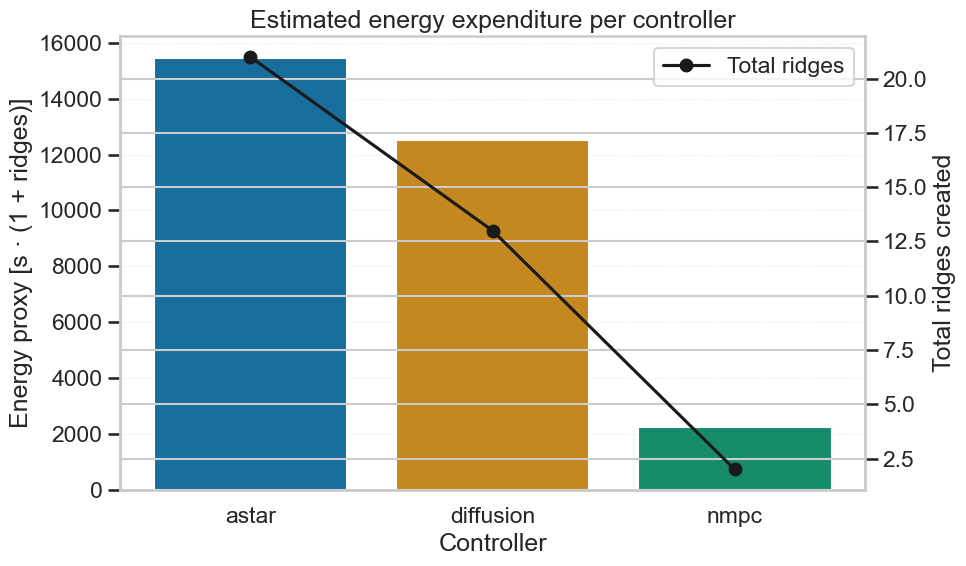

In [140]:
energy_records: list[dict[str, float]] = []
for method in method_order:
    duration = method_durations.get(method)
    if duration is None or pd.isna(duration):
        continue

    ridges = 0.0
    if not ridge_counts_df.empty:
        method_ridges = ridge_counts_df.loc[
            ridge_counts_df['method'] == method, 'cumulative_ridges'
        ]
        if not method_ridges.empty:
            ridges = float(method_ridges.max())

    energy_proxy = duration * (1 + ridges)
    energy_records.append(
        {
            'method': method,
            'normalized_duration_s': duration,
            'total_ridges': ridges,
            'energy_proxy': energy_proxy,
        }
    )

energy_df = pd.DataFrame(energy_records)
if energy_df.empty:
    raise RuntimeError("Could not derive any energy proxy entries.")

display(energy_df.set_index('method').round(2))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=energy_df,
    x='method',
    y='energy_proxy',
    palette=[color_map[m] for m in energy_df['method']],
    ax=ax,
)
ax.set_ylabel('Energy proxy [s · (1 + ridges)]')
ax.set_xlabel('Controller')
ax.set_title('Estimated energy expenditure per controller')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.4)

ax2 = ax.twinx()
ax2.plot(
    ax.get_xticks(),
    energy_df['total_ridges'],
    color='k',
    
    marker='o',
    label='Total ridges',
)
ax2.set_ylabel('Total ridges created')
if ax2.get_legend_handles_labels()[0]:
    ax2.legend(loc='upper right')

sns.despine(ax=ax, right=False)
fig.tight_layout()


In [141]:
def total_ridges_for(method: str) -> float:
    if ridge_counts_df.empty:
        return np.nan
    method_ridges = ridge_counts_df.loc[
        ridge_counts_df['method'] == method, 'cumulative_ridges'
    ]
    return float(method_ridges.max()) if not method_ridges.empty else np.nan

summary_rows = []
for method in method_order:
    summary_rows.append(
        {
            'method': method,
            'total_line_length': path_length_map.get(method),
            'ridge_count': total_ridges_for(method),
            'simulation_time_s': method_durations.get(method),
        }
    )

latex_df = pd.DataFrame(summary_rows)
display(latex_df.round(2))
latex_str = latex_df.round(2).to_latex(index=False)
print("\nLaTeX table:\n")
print(latex_str)


,method,total_line_length,ridge_count,simulation_time_s
0,astar,698.11,21.0,702.44
1,diffusion,681.39,13.0,894.94
2,nmpc,840.35,2.0,748.59



LaTeX table:

\begin{tabular}{lrrr}
\toprule
   method &  total\_line\_length &  ridge\_count &  simulation\_time\_s \\
\midrule
    astar &             698.11 &         21.0 &             702.44 \\
diffusion &             681.39 &         13.0 &             894.94 \\
     nmpc &             840.35 &          2.0 &             748.59 \\
\bottomrule
\end{tabular}



/var/folders/jc/ghwkjyzs21356phts1q28h600000gn/T/ipykernel_14466/2925050277.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_str = latex_df.round(2).to_latex(index=False)


In [142]:
def summarize_relative_improvements(df: pd.DataFrame) -> None:
    best_energy = df['energy_proxy'].min()
    best_ridges = df['total_ridges'].min()

    print('Relative improvements compared to best controller (percent):\n')
    for _, row in df.iterrows():
        method = row['method']

        print(f"• {method}:")
        print(f"  Energy proxy: {row['energy_proxy']:+.1f}%")
        print(f"  Ridge count: {row['total_ridges']:+.1f}%\n")

summarize_relative_improvements(energy_df.reset_index(drop=True))

Relative improvements compared to best controller (percent):

• astar:
  Energy proxy: +15453.8%
  Ridge count: +21.0%

• diffusion:
  Energy proxy: +12529.2%
  Ridge count: +13.0%

• nmpc:
  Energy proxy: +2245.8%
  Ridge count: +2.0%

